# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [600]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

# import libraries
import re
from sqlalchemy import create_engine
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download(['punkt', 'stopwords', 'wordnet']) # for word_tokenize, stopwords and lemmatizer, respectively 
from nltk.stem.wordnet import WordNetLemmatizer

# Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [601]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [602]:
# df Overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null float64
title         45993 non-null object
email         45976 non-null object
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [603]:
# Change type of article_id to string
df['article_id'] = df['article_id'].astype(str)
print("some examples of e-mail values: \n \n ", df.sample(5)['email'])
print("\n \nsome examples of title values: \n \n ", df.sample(5)['title'])

some examples of e-mail values: 
 
  11594    d470b1ea3041a1b46dd1b57e68ad71e14037c5c9
9376     baf4b7807994ed5dfe3ff56ad144bafafa1ce8d9
32705    ceef2a24a2a82031246814b73e029edba51e8ea9
18011    c9086fbe74843c4792d030260be1499c558edc03
6543     4f5271af6ac13fec5d0416cbca4790cc28d1042e
Name: email, dtype: object

 
some examples of title values: 
 
  14943    got zip code data? prep it for analytics. – ib...
42039    use decision optimization to schedule league g...
31973                                    uci: forest fires
11661                data science experience documentation
7947     using machine learning to predict value of hom...
Name: title, dtype: object


In [604]:
# Check article_id df
print("quantity of unique article_id : ", df['article_id'].nunique())

quantity of unique article_id :  714


In [605]:
# check quantity of user e-mails
df['email'].nunique()

5148

In [606]:
# df_content
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
doc_body           1042 non-null object
doc_description    1053 non-null object
doc_full_name      1056 non-null object
doc_status         1056 non-null object
article_id         1056 non-null int64
dtypes: int64(1), object(4)
memory usage: 41.3+ KB


In [607]:
# NaN doc_body rows
df_content[df_content['doc_body'].isnull()]

,doc_body,doc_description,doc_full_name,doc_status,article_id
206,NaN,Watch how to convert XML data to CSV format to...,Load XML data into dashDB,Live,206
276,NaN,Love to work in Microsoft Excel? Watch how to ...,Integrate dashDB with Excel,Live,276
484,NaN,See how to evaluate and convert your DDL and S...,Convert IBM Puredata for Analytics to dashDB,Live,483
508,NaN,Watch how to generate SQL-based reports for Cl...,Use dashDB with IBM Embeddable Reporting Service,Live,507
540,NaN,Need to move some data to the cloud for wareho...,Convert data from Oracle to dashDB,Live,539
638,NaN,See how to create a new dashDB instance and po...,Load JSON from Cloudant database into dashDB,Live,637
667,NaN,"See how to connect dashDB, as a source and tar...",Integrate dashDB and Informatica Cloud,Live,666
706,NaN,Aginity Workbench is a free application known ...,Use Aginity Workbench for IBM dashDB,Live,704
842,NaN,Learn how to configure a dashDB connection in ...,Leverage dashDB in Cognos Business Intelligence,Live,839
876,NaN,See how to populate data into a table in your ...,Load data from the desktop into dashDB,Live,873


In [608]:
# Convert article_id in df_content into atring
df_content['article_id'] = df_content['article_id'].astype(float).astype(str)

In [609]:
# checak doc_status columns
print(df_content['doc_status'].value_counts())

Live    1056
Name: doc_status, dtype: int64


In [610]:
# Number of users
df.groupby(['email']).count()['article_id'].max()

364

In [611]:
# Fill in the median and maximum number of user_article interactios below

median_val = df.groupby(['email']).count()['article_id'].median()
max_views_by_user = df.groupby('email').count()['article_id'].max()

print("50% of individuals interact with {} number of articles or fewer.\n".format(median_val))
print("The maximum number of user-article interactions by any 1 user is {}. ".format(max_views_by_user))

50% of individuals interact with 3.0 number of articles or fewer.

The maximum number of user-article interactions by any 1 user is 364. 


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [612]:
# Find and explore duplicate articles

# Check article id
print("There are {} diferent article in the dataset.".format(df_content['article_id'].nunique()))

# Verify the count of articles with more than 1 input
aux = (df_content.groupby('article_id').count()>1)
multiple_article_id = np.where(aux['doc_status'])[0]
print("multipe article_id: ", multiple_article_id)

There are 1051 diferent article in the dataset.
multipe article_id:  [188 200 383 497 582]


In [613]:
# Remove any rows that have the same article_id - only keep the first
# Drop duplicated ids
df_content.drop_duplicates(subset='article_id', keep='first', inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [614]:
df[df['email'].isnull()]

,article_id,title,email
25131,1016.0,why you should master r (even if it might even...,NaN
29758,1393.0,the nurse assignment problem,NaN
29759,20.0,working interactively with rstudio and noteboo...,NaN
29760,1174.0,breast cancer wisconsin (diagnostic) data set,NaN
29761,62.0,data visualization: the importance of excludin...,NaN
35264,224.0,"using apply, sapply, lapply in r",NaN
35276,961.0,beyond parallelize and collect,NaN
35277,268.0,sector correlations shiny app,NaN
35278,268.0,sector correlations shiny app,NaN
35279,268.0,sector correlations shiny app,NaN


In [615]:
unique_articles = df['article_id'].nunique() # The number of unique articles that have at least one interaction
total_articles = df_content['article_id'].nunique() # The number of unique articles on the IBM platform
unique_users = df['email'].nunique()# The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [616]:
# Serie with the quantity of articles per id
n_views_article = df.groupby('article_id').count()['title']

max_views = n_views_article.max() # The most viewed article in the dataset was viewed how many times?
most_viewed_article_id = n_views_article[(n_views_article == max_views)].index[0] # The most viewed article in the dataset as a string with one value following the decimal 


In [617]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [618]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [619]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Group articles by title, count the quantity of interactions and sort in descending order
    top_articles = df.groupby('title').count()['article_id'].sort_values(ascending=False).index.tolist()
    
    # Return the top article titles from df (not df_content)
    return top_articles[:n] 

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Group df by article_id, sort it, and take the article id
    top_articles = df.groupby('article_id').count()['user_id'].sort_values(ascending=False).index.tolist()
 
    return top_articles[:n] # Return the top article ids

In [620]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [621]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [622]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    #Create a user item matrix
    matrix = df.groupby(['user_id', 'article_id']).count().unstack()
    matrix.columns = matrix.columns.droplevel()
    
    user_item = df.groupby(["user_id", "article_id"])["title"].count().unstack()

   
    # Replace nan values to 0's and the other to 1's
    
    user_item = user_item.fillna(value=0)
    user_item[user_item > 0] = 1
    #matrix = matrix.astype(str).replace('\d\.\d', 1, regex=True).replace('nan',0)
    #user_item = matrix.astype(int)
    
    # return the user_item matrix 
    return user_item 

user_item = create_user_item_matrix(df)

In [623]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [624]:
user_item.dot(user_item[user_item.index == 1].T).sort_values(1, ascending=False).index.values[1:]

array([3933,   23, 3782, ..., 2328, 2329, 5149])

In [625]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # Compute similarity of each user to the provided user in put on a dictionary
    
    similarities = user_item.dot(user_item[user_item.index == user_id].T)
    most_similar_users = similarities.sort_values(user_id, ascending=False).index.values[1:]
    
       
    return list(most_similar_users) # return a list of the users in order from most to least similar
        

In [626]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [3933, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [627]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''

    article_names = df[df['article_id'].isin(article_ids)]['title'].unique().tolist()

    # Return the article names associated with list of article ids
    return article_names 


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Select articles for each user_id    
    items_per_user = user_item.loc[user_id]
    article_ids = items_per_user[items_per_user==1].index.tolist()
    
    # Return article names for each user_id
    article_names = get_article_names(article_ids)


    # return the ids and names
    return article_ids, article_names 


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Create a set with the article_ids in similiar users 
    recoms = np.array([])   
    user_articles, _ = get_user_articles(user_id)
    similar_users = find_similar_users(user_id) 

    
    for user in similar_users:
        article_ids , _ = get_user_articles(user)
        
        article_ids = np.setdiff1d(np.setdiff1d(article_ids, user_articles), recoms)
        
        recoms = np.append(recoms, article_ids)
    
        if len(recoms) > (m-1):
            recs = list(recoms)
            break
    
    recs = recs[:m]
        
    # return recommendations for this user_id     
    return recs     

In [628]:
# Check Results
get_article_names(user_user_recs(1)) # Return 10 recommendations for user 1


['analyze energy consumption in buildings',
 'analyze accident reports on amazon emr spark',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'airbnb data for analytics: vancouver listings',
 'recommender systems: approaches & algorithms',
 'airbnb data for analytics: mallorca reviews',
 'analyze facebook data using ibm watson and watson studio',
 'a tensorflow regression model to predict house values']

In [629]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [630]:
top_interact_articles = df.groupby('article_id').count()['user_id']
top_interact_articles.loc[['0.0','101.0','1008.0']].sort_values()

article_id
0.0       14
1008.0    17
101.0     89
Name: user_id, dtype: int64

In [631]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    
    neighbor_id = pd.Series(find_similar_users(user_id), name='user_id')
    neighbor_id.index = neighbor_id.values

    # Create a Series with num_interactions per user_id
    num_interactions = df['user_id'].value_counts()
    num_interactions.name = 'num_interactions'

    # Create the Dataframe with neighbor_id, n_interactions and interactions
    neighbors_df = pd.concat([neighbor_id,num_interactions], axis=1)
    neighbors_df = neighbors_df.dropna()

    calculate_similarity = lambda x: np.dot(user_item.loc[x],user_item.loc[user_id])
    neighbors_df['similarity'] = neighbors_df['user_id'].map(calculate_similarity)
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False).reset_index(drop=True)
    neighbors_df['user_id'] = neighbors_df['user_id'].astype(int)
    
    return neighbors_df# Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Get the user_id of the top sorted users
    recs_df = get_top_sorted_users(user_id)
    similar_users = recs_df['user_id'].values.tolist()
    
    
    # Get the articles which user_id interacted
    user_articles, _ = get_user_articles(user_id)
    
    # Create a serie with the number of interactions by articles_id
    top_interact_articles = df.groupby('article_id').count()['user_id']
    
    
    # For each similar user, choose the diferent articles most viewed
    
    recoms = np.array([])

    for user in similar_users:
        article_ids , _ = get_user_articles(user)
        article_ids = np.setdiff1d(np.setdiff1d(article_ids, user_articles), recoms)
        
        art_ids = top_interact_articles.loc[article_ids].sort_values(ascending=False).index.tolist()     
        
        recoms = np.append(recoms, art_ids)    
        if len(recoms) > (m-1):
            
            recs = list(recoms)
            break
    
    recs = recs[:m]
    rec_names = get_article_names(recs) 
    
    return recs, rec_names
          

In [632]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
['apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'putting a human face on machine learning', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [633]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1)['user_id'].iloc[0]# Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131)['user_id'].iloc[9]# Find the 10th most similar user to user 131

In [634]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**In this case, the Rank-Based Recommendations is the single possible choice, because this approach is based on the popularity of the articles, while Collaborative Filtering method just works for users with some interaction.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [635]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(n=10, df=df)# Your recommendations here



In [636]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [637]:
def tokenize(text):
    """ Transform text string in a token list.
    
    Args:
    text: str. The text to tokenize. 
    stop_words: bool. If is true, remove the stop words 
    lemmatize (bool). If is true, lemmatize the tokens.
    
    Returns:
    tokens: list. Return a list of tokens from the text.
    
    """
    # Normalize text
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-0]'," ", text)
    
    
    #Tokenize text
    tokens = word_tokenize(text)
    
    # Remove stop words
    tokens = [w for w in tokens if w not in stopwords.words("english")]
        
    # Reduce words to their root form
    tokens = [WordNetLemmatizer().lemmatize(w, pos='v') for w in tokens]
    
        
    return tokens   

def pipeline():
    
    """ 
    Pipeline that transform text data in a matrix. 
    
    """
    
    # Instantiate pipeline
    pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)), 
    ('tfidf', TfidfTransformer()),
    ])
    
    return pipeline

def make_content_recs(article_id, n_recs):
    '''
    INPUT:
    article_id: article_id string
    n_recs: 
    
    OUTPUT:
    recs:
    
    '''
    # Create Dataframe with article_id and article doc_description
    articles = df_content.groupby('article_id').max()['doc_description']
    
    # Drop articles without description
    articles = articles.dropna()
    
    # Article_id array
    art_ids = articles.index.values
    
    #Article descriptions array
    X = np.array(articles)
    
    # Instiate the model, fit, and transform X array
    model = pipeline()
    X_new = model.fit_transform(X)
    X_new = X_new.toarray()
    
    # Create the Similarity Matrix of the articles 
    article_sims = np.dot(X_new,X_new.T)
    
    # Given an article, get the similarities between it and the others
    position = np.where(article_id == art_ids)[0][0]
    similarities_array = article_sims[:,position]

    # Sort by descending order
    desc_order_pos = np.argsort(similarities_array)[::-1]
    
    #similarities_array[desc_order_pos]
    desc_art_ids = art_ids[desc_order_pos]
    
    return desc_art_ids[1:n_recs+1]


`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**I chose to create an algorithm that takes into account the column `doc_description` to measure the similarity between the articles. Thus, the algorithm basically recommends the n items closest to a given item already in the set. This approach can be useful for users for whom Collaborative Filtering did not work or for new users.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [638]:
# make a recommendations for a user who only has interacted with article id '53.0'
recs = make_content_recs('53.0', 10)
recs

array(['670.0', '339.0', '194.0', '0.0', '651.0', '730.0', '801.0',
       '470.0', '980.0', '384.0'], dtype=object)

In [639]:
# Searched Article 
art_name = df_content.loc[df_content['article_id'] == '53.0']['doc_full_name'].values[0]

# Related Articles
print("Related to {}: \n".format(art_name))
related_arts = df_content.loc[df_content['article_id'].isin(recs),'doc_full_name'].values
counter = 1
for i in related_arts:
    print("{} - {}".format(counter,i))
    counter+=1

Related to Introducing Streams Designer: 

1 - Detect Malfunctioning IoT Sensors with Streaming Analytics
2 - Data science for real-time streaming analytics
3 - Get started with Streams Designer by following this roadmap
4 - Continuous Learning on Watson
5 - What’s new in the Streaming Analytics service on Bluemix
6 - Analyzing streaming Data from Kafka Topics
7 - Calculate moving averages on real time data with Streams Designer
8 - Developing for the IBM Streaming Analytics service
9 - Sentiment Analysis of Twitter Hashtags
10 - logshare


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [640]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [641]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [642]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=True) 

In [643]:
u.shape

(5149, 5149)

In [644]:
s.shape

(714,)

In [645]:
vt.shape

(714, 714)

**The main difference here is that the user-item matrix has no missing values. Thus, it was possible to use the Singular Value Decompostion function in place of the FunkSVD technique.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

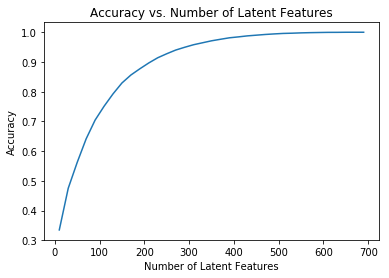

In [646]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [647]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index.values
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [648]:
# user_id array in each group
user_qty_test = len(test_idx)
user_qty_train = len(df_train.user_id.unique())

In [649]:
# Number of user in both groups
len(np.intersect1d(df_train.user_id.unique(),test_idx))


20

In [650]:
# Number of articles we can make predictions
article_qty_test = test_arts
article_qty_train = df_train.article_id.unique()

len(np.intersect1d(article_qty_test,article_qty_train))

574

In [651]:
# Number od articles in test set that we are not able to make predicitons
len(article_qty_test) - len(np.intersect1d(article_qty_test,article_qty_train))

0

In [652]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [653]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=True)

In [654]:
# Create test and train user-item matrix with the same dimension 
train_idx = user_item_train.index.values
train_arts = user_item_train.columns

idx = np.intersect1d(train_idx, test_idx)
cols = np.intersect1d(train_arts, test_arts)

user_item_test_2 = user_item_test.loc[idx,cols]
user_item_train_2 = user_item_train.loc[idx,cols]

print("Dimension of the test user_item matrix: {} x {}".format(user_item_test_2.shape[0], user_item_test_2.shape[1]))
print("Dimension of the train user_item  matrix: {} x {}".format(user_item_train_2.shape[0], user_item_train_2.shape[1]))

Dimension of the test user_item matrix: 20 x 574
Dimension of the train user_item  matrix: 20 x 574


In [655]:
# Create a boolean mask for rows and columns of the numpy array 
new_idx = []
for i in train_idx:
    if i in idx:
        new_idx.append(True)
    else:
        new_idx.append(False)        
        
new_col = []
for i in train_arts:
    if i in cols:
        new_col.append(True)
    else:
        new_col.append(False) 

In [656]:
# Calculate train and test errors

num_latent_feats = np.arange(10,700+10,20)
sum_errs_test = []
sum_errs_train = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new= np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_estim = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    user_item_estim = user_item_estim[new_idx,:]
    user_item_estim = user_item_estim[:,new_col]
    
    
    # compute error for each prediction to actual value
    diffs_test = np.subtract(user_item_test_2, user_item_estim)
    diffs_train = np.subtract(user_item_train_2, user_item_estim)
    
    
    # total errors and keep track of them
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_test.append(err_test)
    
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    sum_errs_train.append(err_train)   
   


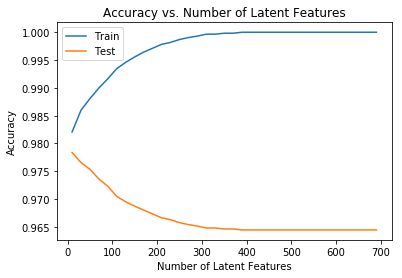

In [657]:
# Plot train and test cruves
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(len(idx)*len(cols)), label="Train");
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(len(idx)*len(cols)), label="Test");
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend();

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**The results above show the accuracy in the training set (blue curve) and in the test set (orange curve). In the training set, as expected, the accuracy of the results increases as the number of latent features used increases, approaching 1. In the test set, the accuracy decreases as the number of latent features increases, with an inverse tendency to the trend of training curve, which can be due to overfitting. However, since the `user_item` matrix is sparse, any solution that has many zeros in the results will be highly accurate. Therefore, accuracy may not be a good metric to demonstrate the performance of this solution.**

**In addition, for the evaluation of the test set to be reliable, it is necessary for the group to have around 20% of the sample of the training set. However, the amount available was 11480, around 3.5% of what was used in the training set (3203718). Finally, A/B testing can be a means of evaluating SVD performance and in this case, the control group would be the actual data while the experimental group would be the results provided by the SVD.**



<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [658]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0